# Laboratorium 8. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


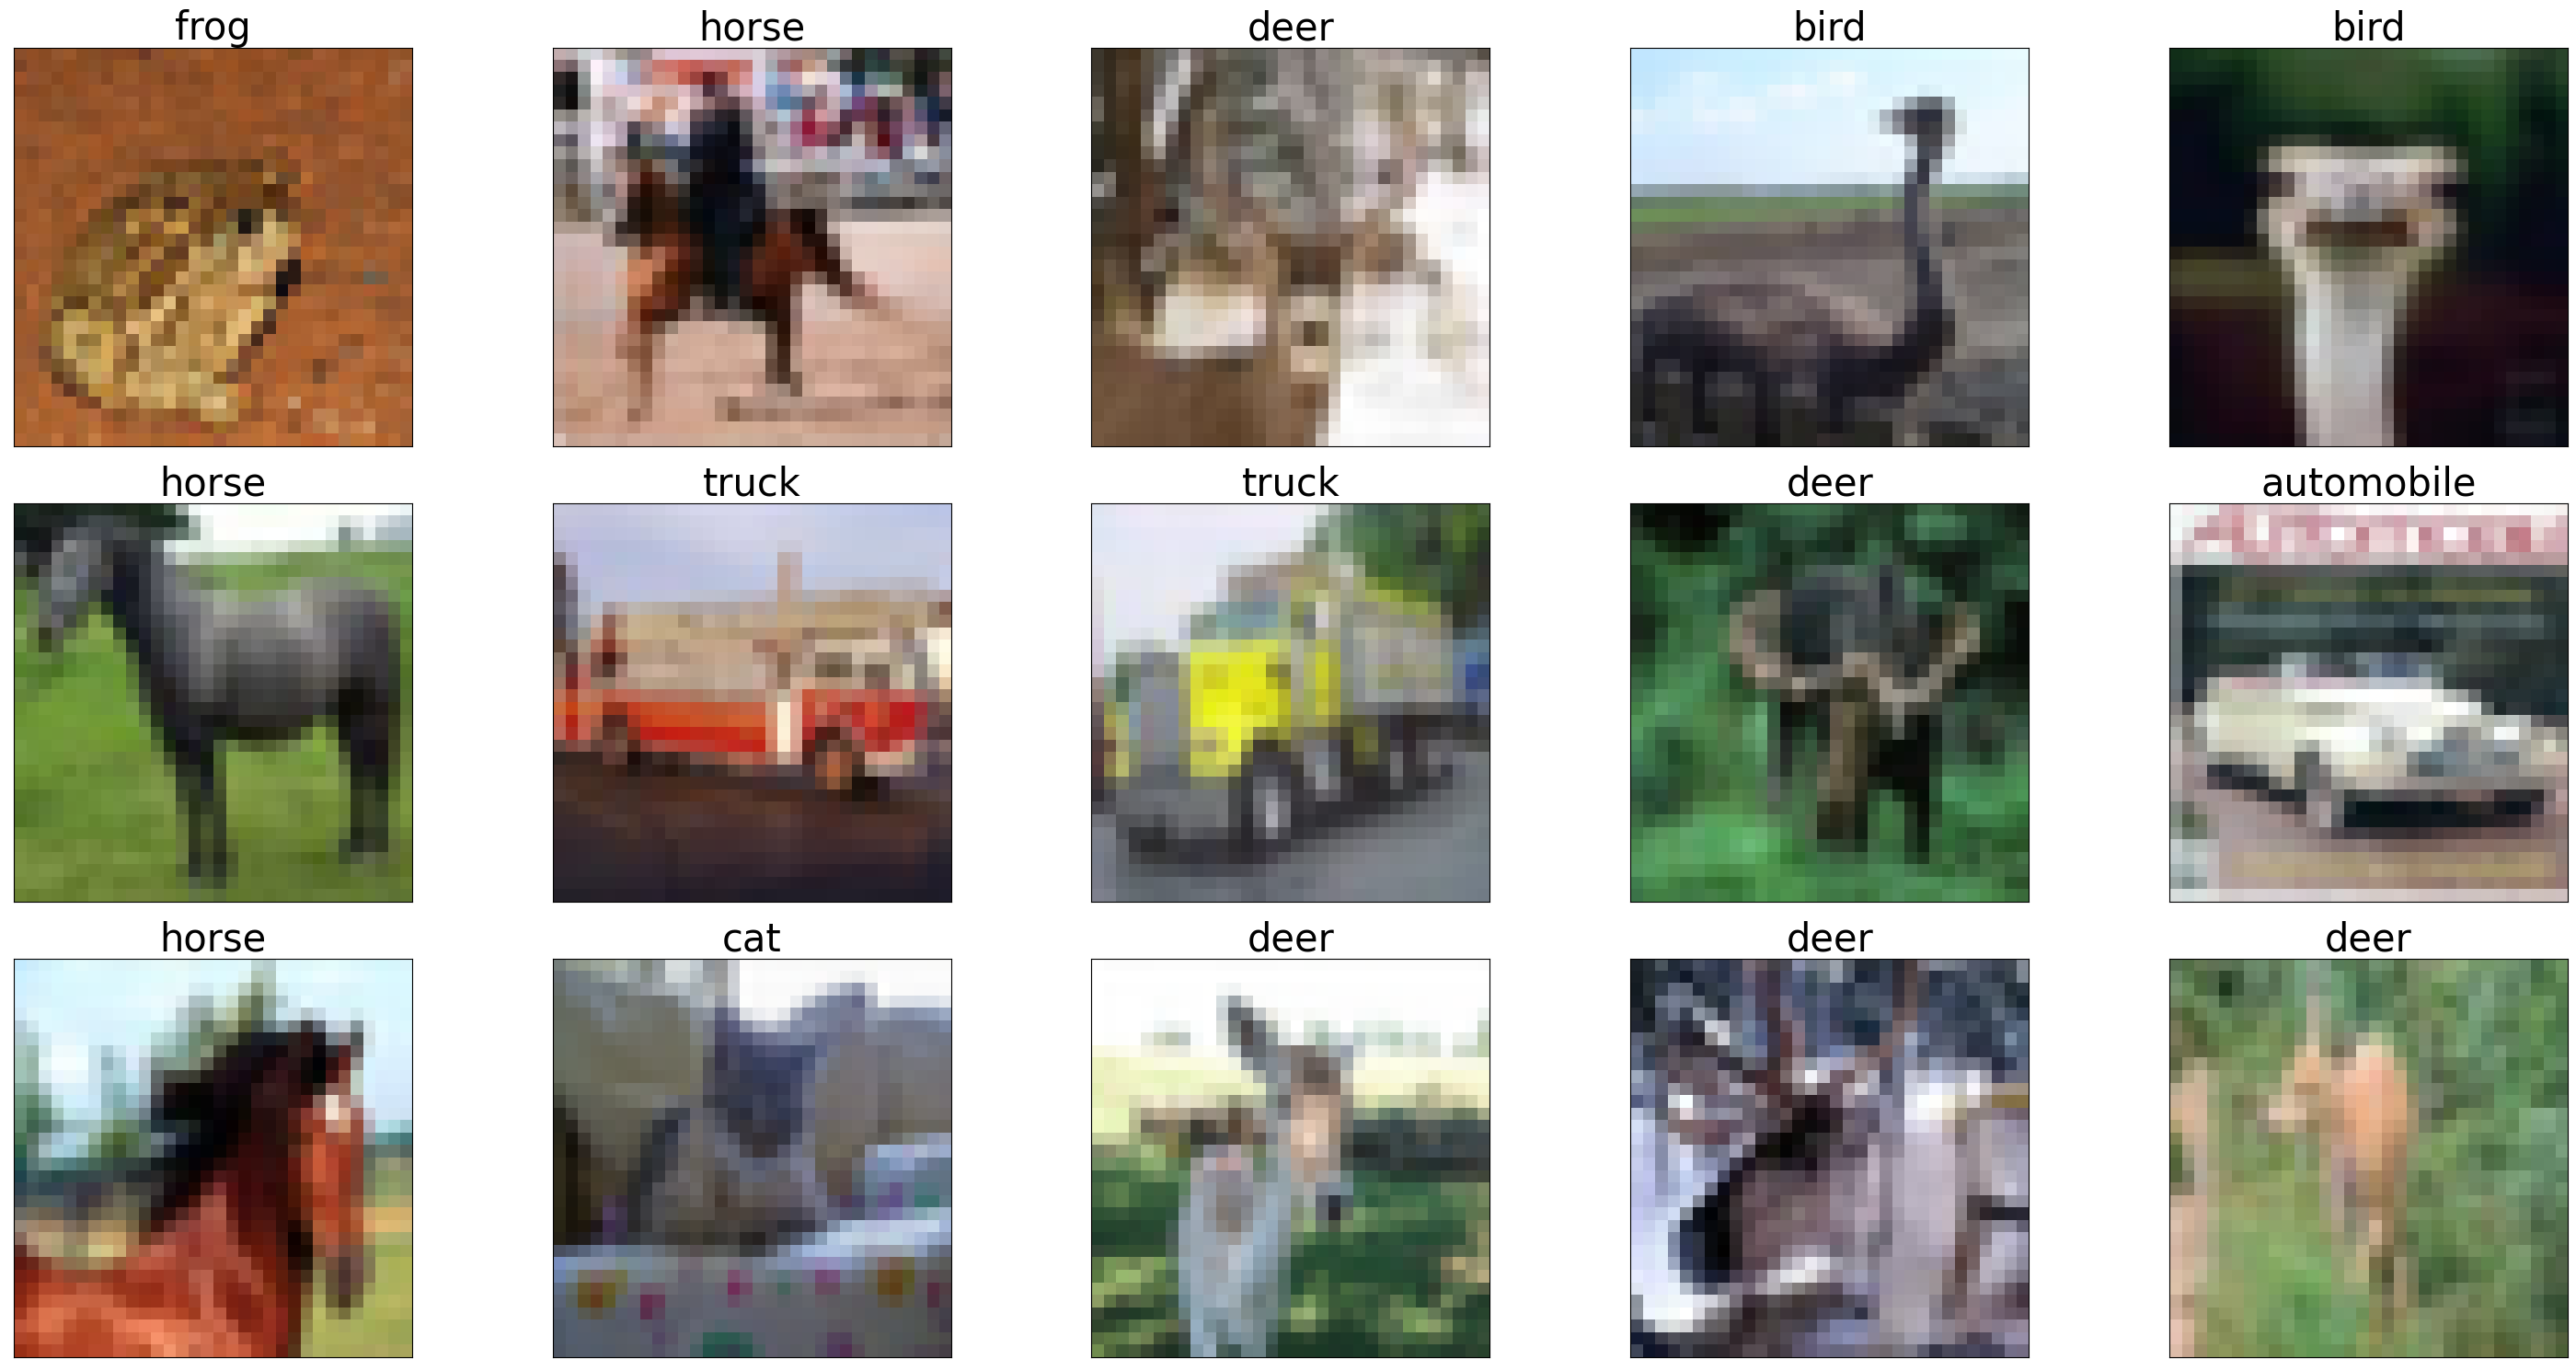

In [2]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [9]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module

class CIFAR10ConvNet(torch.nn.Module):
    def __init__(self):
        super(CIFAR10ConvNet, self).__init__()

        # define layers
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 4 * 4, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, 10)

        # define activation functions
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [10]:
import torchvision.transforms as transforms


# tutaj uzupełnij ładowanie danych treningowych i testowych

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CIFAR10ConvNet().to(device)

# specify loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# set number of epochs
num_epochs = 10

# lists to store training and validation losses
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # initialize batch loss
    batch_loss = 0

    # iterate over train_loader
    for data, labels in train_loader:
        # move data and labels to device
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # add loss to batch_loss
        batch_loss += loss.item()

    # append average batch loss to train_losses
    train_losses.append(batch_loss / len(train_loader))

    # set model to evaluation mode
    model.eval()

    # initialize batch loss
    batch_loss = 0

    # disable gradient computation
    with torch.no_grad():
        # iterate over test_loader
        for data, labels in test_loader:
            # move data and labels to device
            data, labels = data.to(device), labels.to(device)

            # forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # add loss to batch_loss
            batch_loss += loss.item()

    # append average batch loss to valid_losses
    valid_losses.append(batch_loss / len(test_loader))

    # print epoch loss
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')


Epoch 1/10, Train Loss: 2.1181, Validation Loss: 2.0342
Epoch 2/10, Train Loss: 2.0030, Validation Loss: 1.9488
Epoch 3/10, Train Loss: 1.9443, Validation Loss: 1.9440
Epoch 4/10, Train Loss: 1.9000, Validation Loss: 1.8948
Epoch 5/10, Train Loss: 1.8695, Validation Loss: 1.8723
Epoch 6/10, Train Loss: 1.8391, Validation Loss: 1.8503
Epoch 7/10, Train Loss: 1.8165, Validation Loss: 1.8269
Epoch 8/10, Train Loss: 1.7936, Validation Loss: 1.8133
Epoch 9/10, Train Loss: 1.7736, Validation Loss: 1.8142
Epoch 10/10, Train Loss: 1.7590, Validation Loss: 1.8001


## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

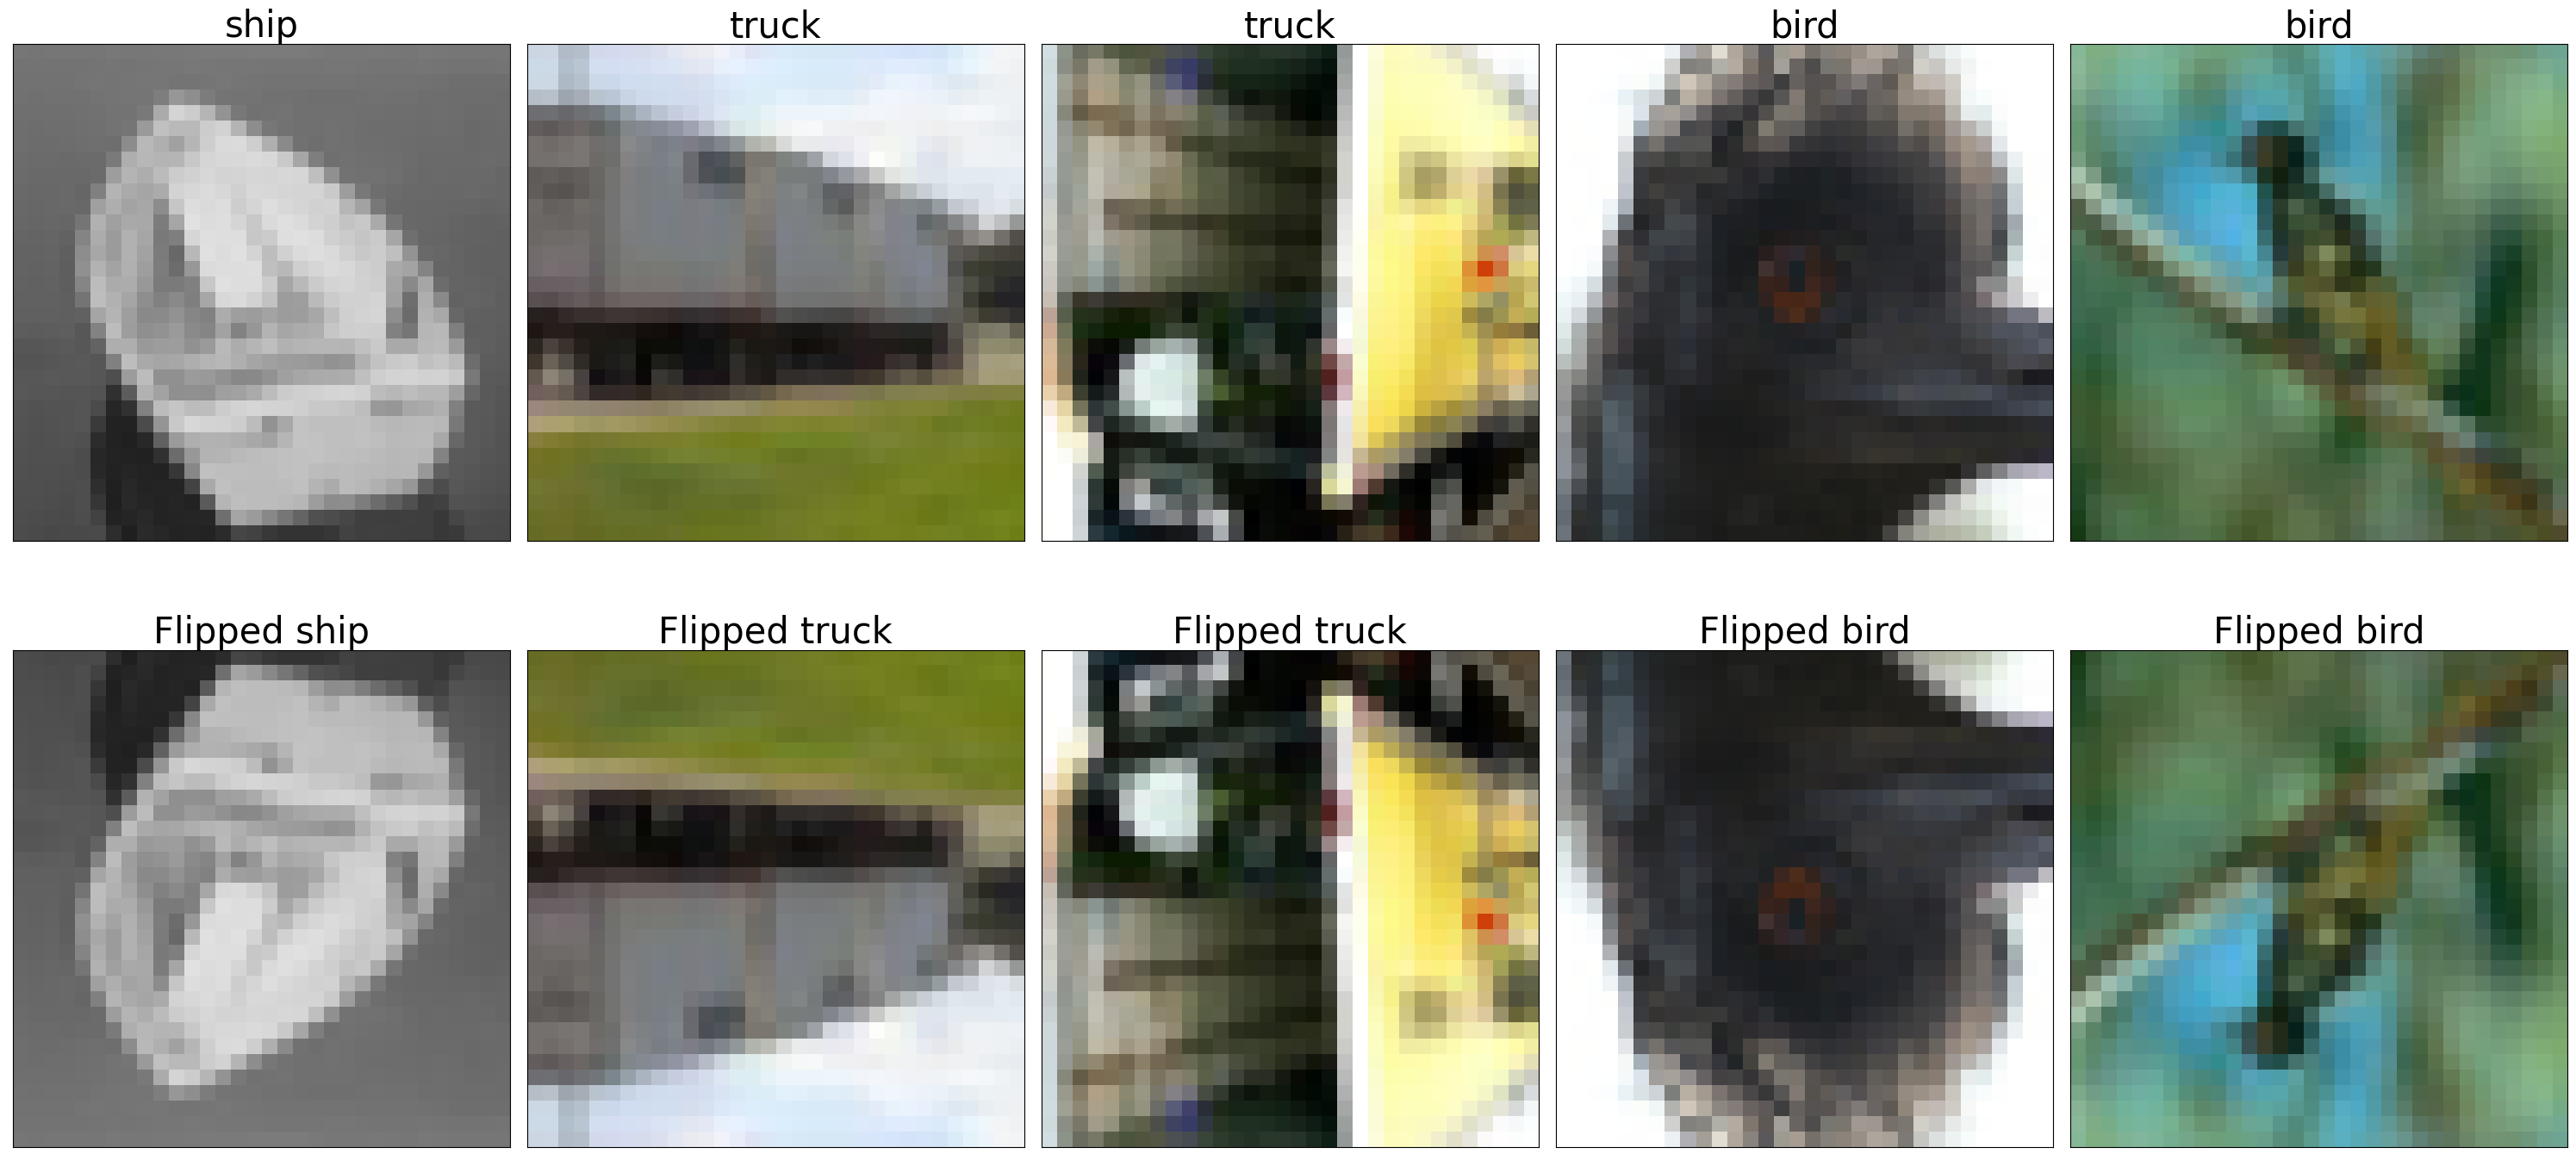

In [12]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [ ]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

In [13]:
# tutaj powtórz pętle uczenia z poprzedniego zadania

# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CIFAR10ConvNet().to(device)

# specify loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# set number of epochs
num_epochs = 10

# lists to store training and validation losses
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # initialize batch loss
    batch_loss = 0

    # iterate over train_loader
    for data, labels in train_loader:
        # move data and labels to device
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # add loss to batch_loss
        batch_loss += loss.item()

    # append average batch loss to train_losses
    train_losses.append(batch_loss / len(train_loader))

    # set model to evaluation mode
    model.eval()

    # initialize batch loss
    batch_loss = 0

    # disable gradient computation
    with torch.no_grad():
        # iterate over test_loader
        for data, labels in test_loader:
            # move data and labels to device
            data, labels = data.to(device), labels.to(device)

            # forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # add loss to batch_loss
            batch_loss += loss.item()

    # append average batch loss to valid_losses
    valid_losses.append(batch_loss / len(test_loader))

    # print epoch loss
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {valid_losses[-1]:.4f}')


Epoch 1/10, Train Loss: 2.0991, Validation Loss: 1.9962
Epoch 2/10, Train Loss: 1.9782, Validation Loss: 1.9322
Epoch 3/10, Train Loss: 1.9229, Validation Loss: 1.8966
Epoch 4/10, Train Loss: 1.8735, Validation Loss: 1.9010
Epoch 5/10, Train Loss: 1.8449, Validation Loss: 1.8412
Epoch 6/10, Train Loss: 1.8201, Validation Loss: 1.8188
Epoch 7/10, Train Loss: 1.7994, Validation Loss: 1.8289
Epoch 8/10, Train Loss: 1.7873, Validation Loss: 1.8141
Epoch 9/10, Train Loss: 1.7691, Validation Loss: 1.8193
Epoch 10/10, Train Loss: 1.7543, Validation Loss: 1.8046


## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [14]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [15]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

C:\Users\patry\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\patry\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


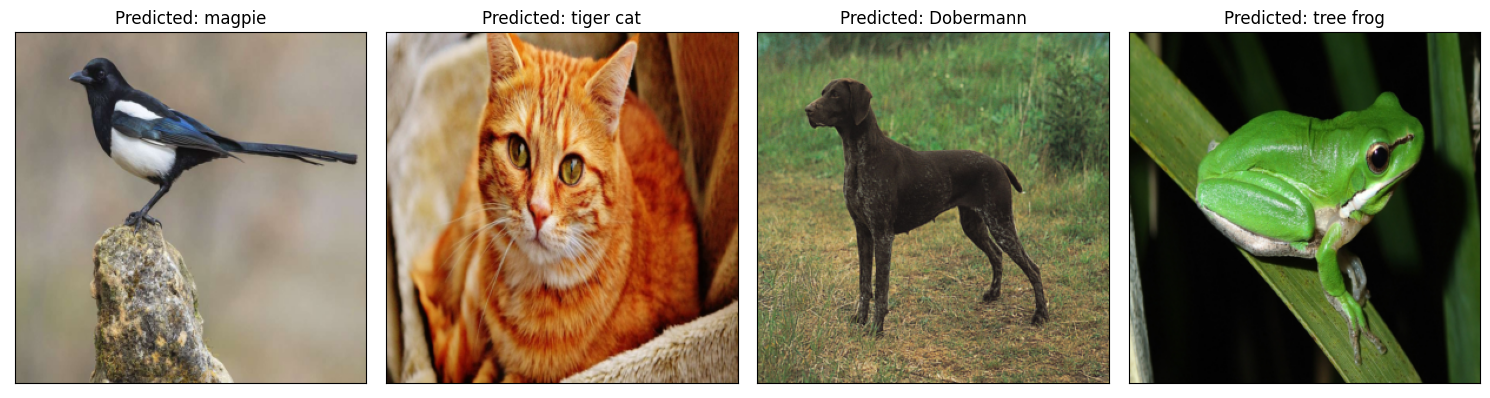

In [16]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [17]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

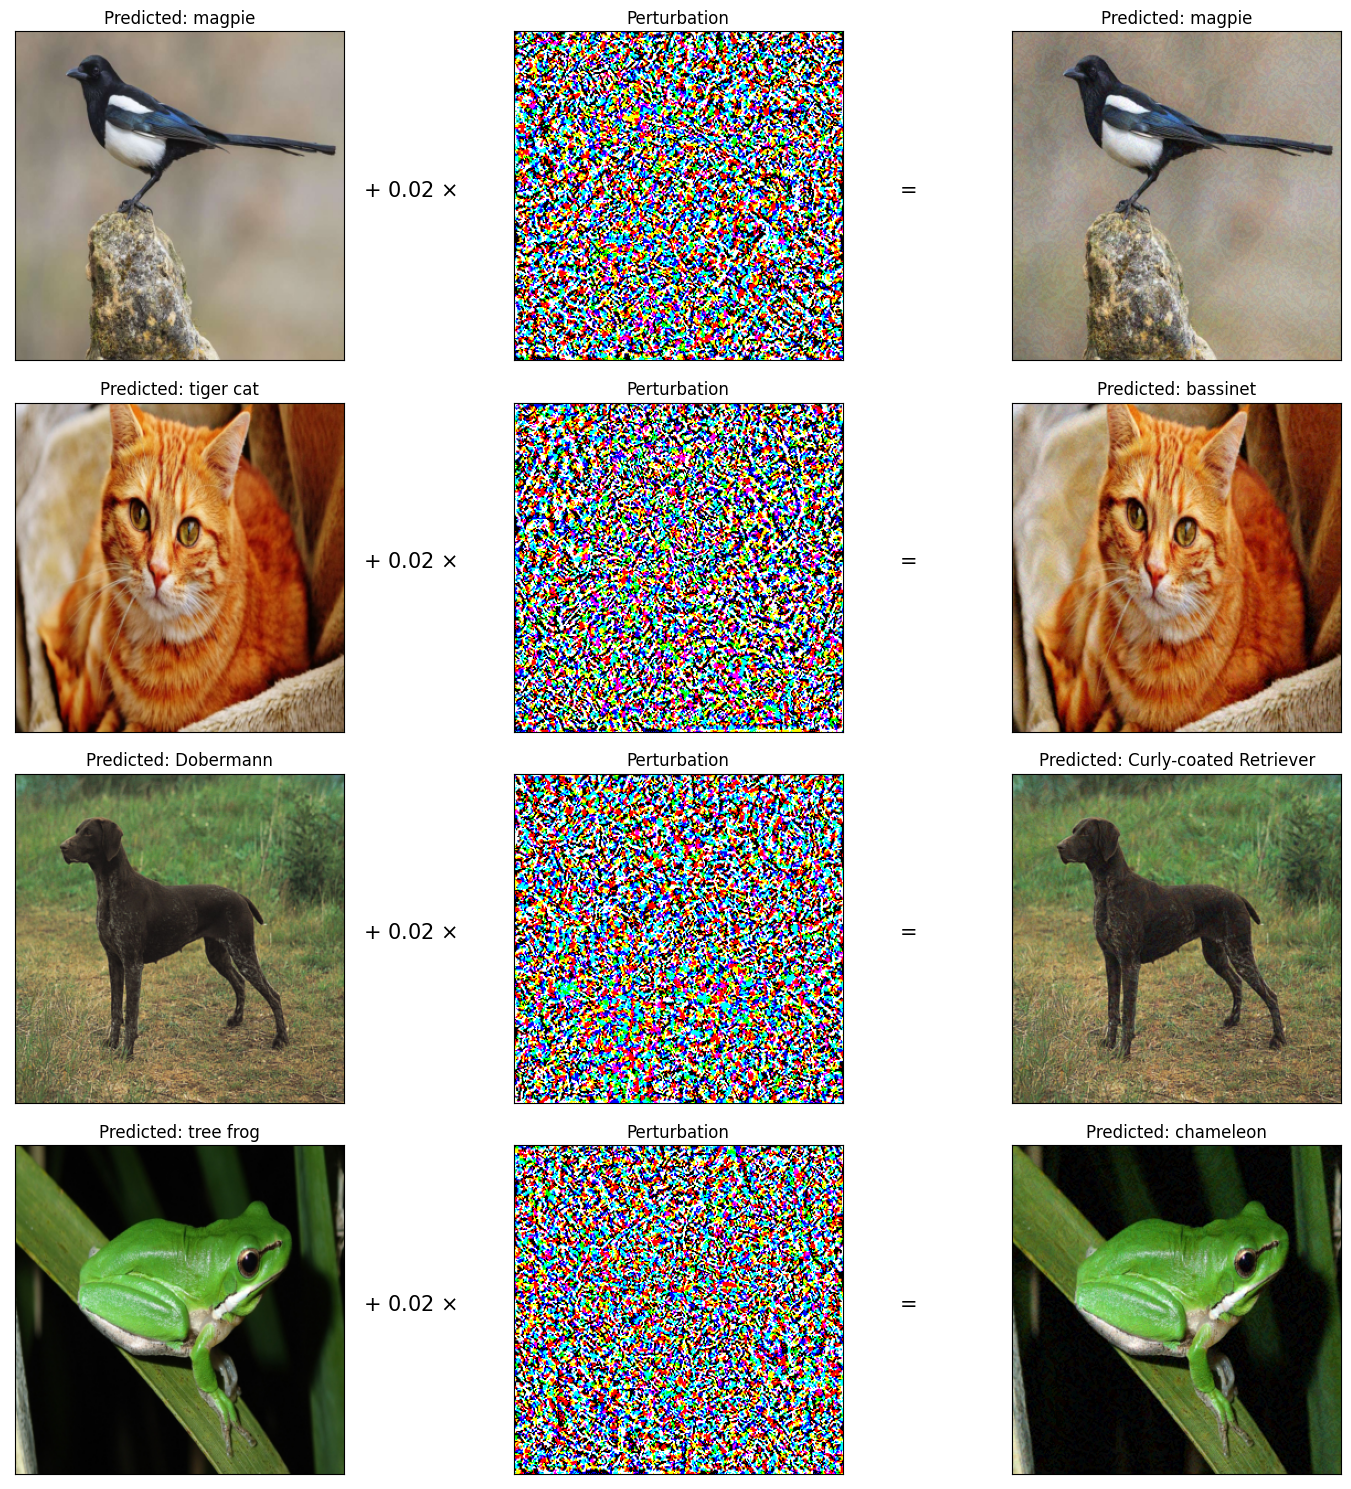

In [18]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji.

In [ ]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizację!

In [ ]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych

In [17]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu